In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 2
lambda_ = 0.9999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.01, 0.001]), 'fb': np.array([0.001, 0.001])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 20
neural_dynamic_iterations_free = 20
hopfield_g = 0.05

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.10575


In [6]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 25

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        if True:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield_noEP( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [00:35, 83.49it/s]
8it [00:00, 74.91it/s]

Epoch : 1, Train Accuracy : 0.15455, Test Accuracy : 0.1547


3000it [00:36, 82.55it/s]
8it [00:00, 74.18it/s]

Epoch : 2, Train Accuracy : 0.21271666666666667, Test Accuracy : 0.2147


3000it [00:36, 81.72it/s]
8it [00:00, 74.35it/s]

Epoch : 3, Train Accuracy : 0.2581, Test Accuracy : 0.2608


3000it [00:36, 81.36it/s]
8it [00:00, 75.24it/s]

Epoch : 4, Train Accuracy : 0.25903333333333334, Test Accuracy : 0.2596


3000it [00:37, 79.44it/s]
8it [00:00, 75.77it/s]

Epoch : 5, Train Accuracy : 0.31035, Test Accuracy : 0.3182


3000it [00:37, 81.06it/s]
8it [00:00, 76.26it/s]

Epoch : 6, Train Accuracy : 0.45071666666666665, Test Accuracy : 0.4553


3000it [00:36, 82.16it/s]
8it [00:00, 75.69it/s]

Epoch : 7, Train Accuracy : 0.44028333333333336, Test Accuracy : 0.4375


3000it [00:36, 82.33it/s]
8it [00:00, 75.13it/s]

Epoch : 8, Train Accuracy : 0.5207, Test Accuracy : 0.5172


3000it [00:36, 82.27it/s]
8it [00:00, 74.81it/s]

Epoch : 9, Train Accuracy : 0.52205, Test Accuracy : 0.5246


3000it [00:36, 81.86it/s]
8it [00:00, 74.69it/s]

Epoch : 10, Train Accuracy : 0.49628333333333335, Test Accuracy : 0.4937


3000it [00:36, 81.14it/s]
8it [00:00, 74.29it/s]

Epoch : 11, Train Accuracy : 0.5450833333333334, Test Accuracy : 0.5519


3000it [00:36, 81.24it/s]
8it [00:00, 76.01it/s]

Epoch : 12, Train Accuracy : 0.32915, Test Accuracy : 0.3363


3000it [00:37, 80.93it/s]
8it [00:00, 75.76it/s]

Epoch : 13, Train Accuracy : 0.5430333333333334, Test Accuracy : 0.5475


3000it [00:36, 81.88it/s]
8it [00:00, 75.81it/s]

Epoch : 14, Train Accuracy : 0.5506333333333333, Test Accuracy : 0.5596


3000it [00:35, 83.62it/s]
8it [00:00, 75.04it/s]

Epoch : 15, Train Accuracy : 0.19308333333333333, Test Accuracy : 0.1842


3000it [00:35, 83.63it/s]
8it [00:00, 78.75it/s]

Epoch : 16, Train Accuracy : 0.4209, Test Accuracy : 0.4216


3000it [00:37, 80.16it/s]
8it [00:00, 79.37it/s]

Epoch : 17, Train Accuracy : 0.42236666666666667, Test Accuracy : 0.4269


3000it [00:37, 79.12it/s]
8it [00:00, 79.30it/s]

Epoch : 18, Train Accuracy : 0.45286666666666664, Test Accuracy : 0.4524


3000it [00:38, 77.35it/s]
9it [00:00, 81.81it/s]

Epoch : 19, Train Accuracy : 0.38945, Test Accuracy : 0.3918


3000it [00:38, 77.71it/s]
9it [00:00, 81.86it/s]

Epoch : 20, Train Accuracy : 0.31601666666666667, Test Accuracy : 0.3216


3000it [00:38, 77.54it/s]
8it [00:00, 78.01it/s]

Epoch : 21, Train Accuracy : 0.4810833333333333, Test Accuracy : 0.4896


3000it [00:37, 79.83it/s]
9it [00:00, 81.97it/s]

Epoch : 22, Train Accuracy : 0.33615, Test Accuracy : 0.3363


3000it [00:37, 79.32it/s]
8it [00:00, 77.73it/s]

Epoch : 23, Train Accuracy : 0.38988333333333336, Test Accuracy : 0.3927


3000it [00:38, 78.32it/s]
8it [00:00, 79.77it/s]

Epoch : 24, Train Accuracy : 0.19088333333333332, Test Accuracy : 0.1902


3000it [00:38, 77.70it/s]


Epoch : 25, Train Accuracy : 0.36816666666666664, Test Accuracy : 0.3752


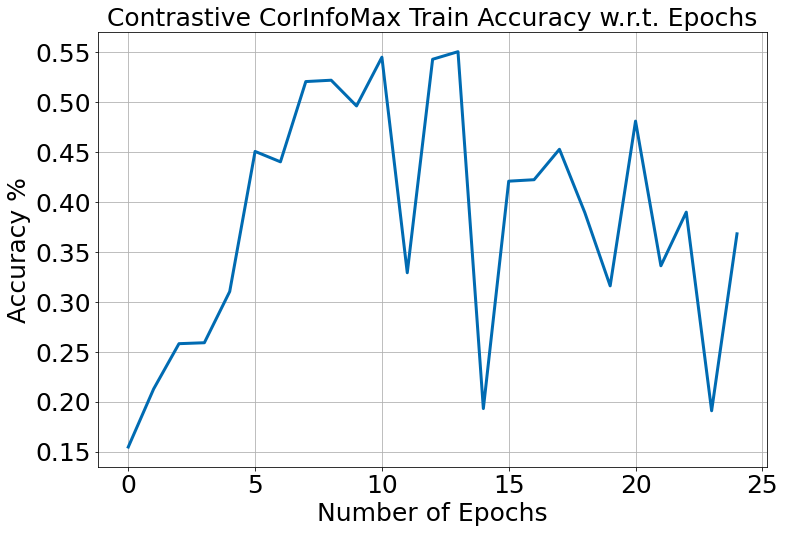

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

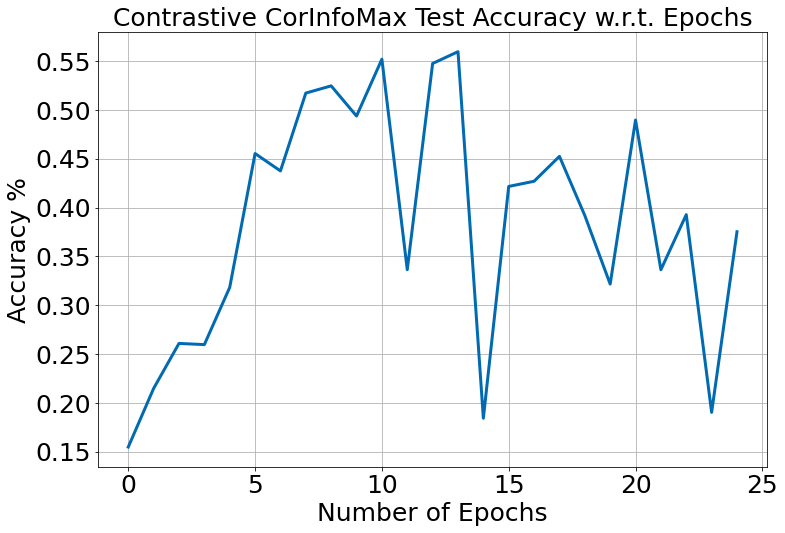

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [9]:
from IPython.display import Math, display
########### LATEX Style Display Matrix ###############
def display_matrix(array):
    """Display given numpy array with Latex format in Jupyter Notebook.
    Args:
        array (numpy array): Array to be displayed
    """
    data = ""
    for line in array:
        if len(line) == 1:
            data += " %.3f &" % line + r" \\\n"
            continue
        for element in line:
            data += " %.3f &" % element
        data += r" \\" + "\n"
    display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [10]:
display_matrix(model.B[0]['weight'][:10,:10])

<IPython.core.display.Math object>

In [11]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [12]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [13]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])